# Visualizing PCEN-SNR segmentation of bird field recordings

The purpose of this notebook is to visualize how PCEN-SNR segments audio depending on the parameters used. The particular use case is researching syllable sequencing patterns in birdsong across species, and the goals of using PCEN-SNR are to a) eliminate files of poor quality, and b) find excerpts of 'good' audio within the files. 

At the beginning of each recording's file name is "q" followed by a number. These are very rough quality ratings that I made based on my supervisor's reaction to the usability of the file:
* q0 = poor quality (probably not usable)
* q1 = medium quality (maybe usable)
* q2 = high quality (probably usable)

At the moment, this notebook only visualizes how PCEN-SNR finds activity in the files, not how it evaluates the quality of a file as a whole. 

This notebook could be used with any list of audio files. 

In [201]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [202]:
# import dependencies
import os
import copy
import librosa
import librosa.display
import matplotlib
from matplotlib import pyplot as plt
import sys
import numpy as np
from numpy import matlib
import scipy.signal

# tell jupyter notebook to show the plots inline
%matplotlib inline

# define and add paths
dir_beg = '/home/kendra/Documents/sakata-rotation/birdsong-patterns'
dir_data = dir_beg + '/data/audio_for_visualization_notebook'
dir_function = dir_beg + '/src'
sys.path.append('./src')

# get function
os.chdir(dir_function)
from pcen_snr import detect_activity

# get list of audio files
os.chdir(dir_data) # need to be in the directory to load the file with librosa
audio_list = os.listdir() 

# set parameters
n_mels=128
fmin=1000
fmax=11025
hop_length=512
gain=0.8
bias=10
power=0.25
pcen_time_constant=0.06
eps=1e-06
medfilt_time_constant=.5
normalized=False
peak_threshold=1
activity_threshold=0.2

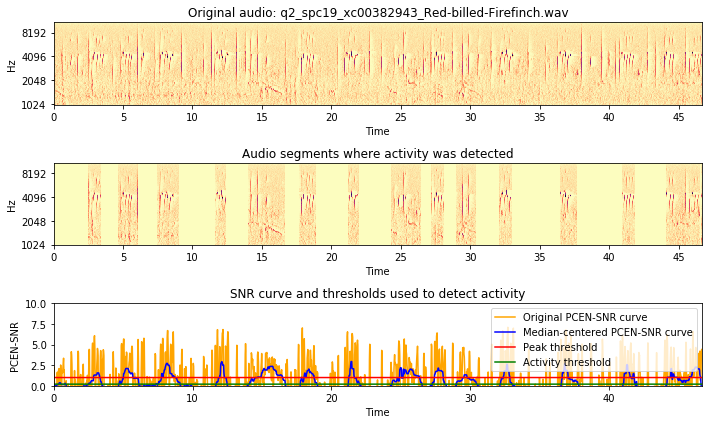

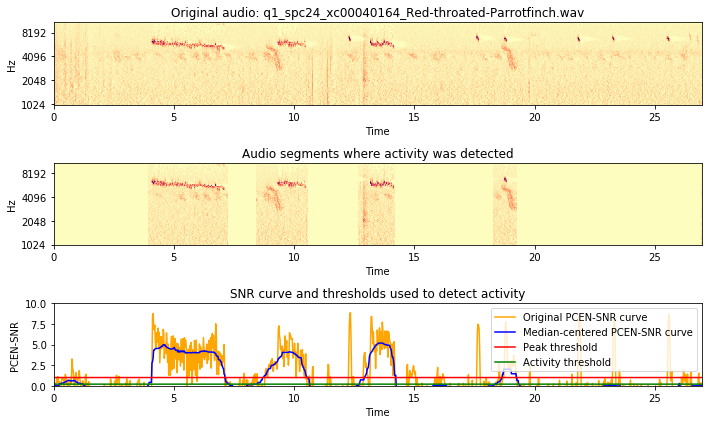

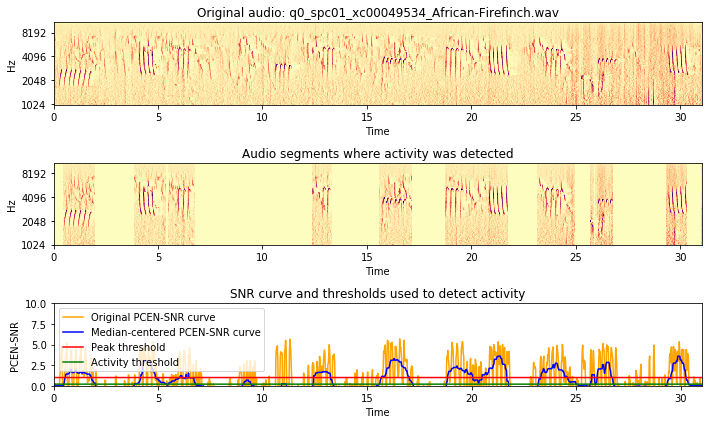

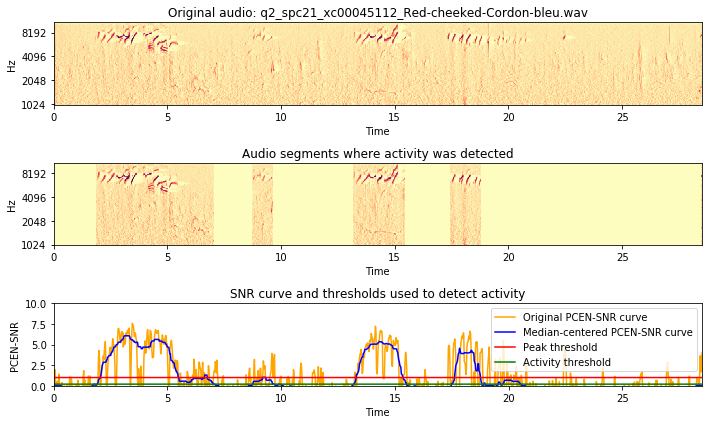

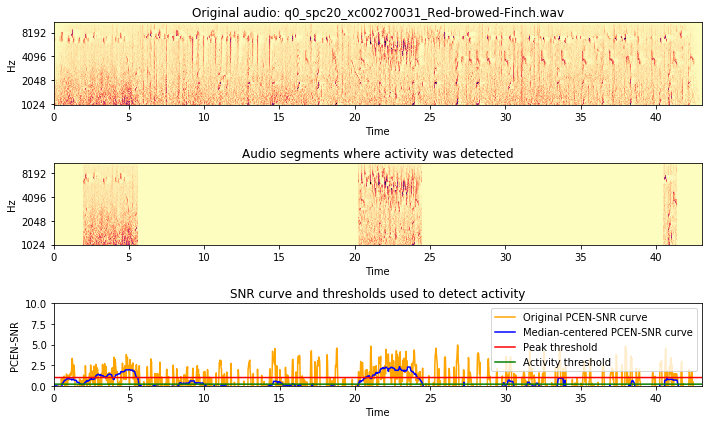

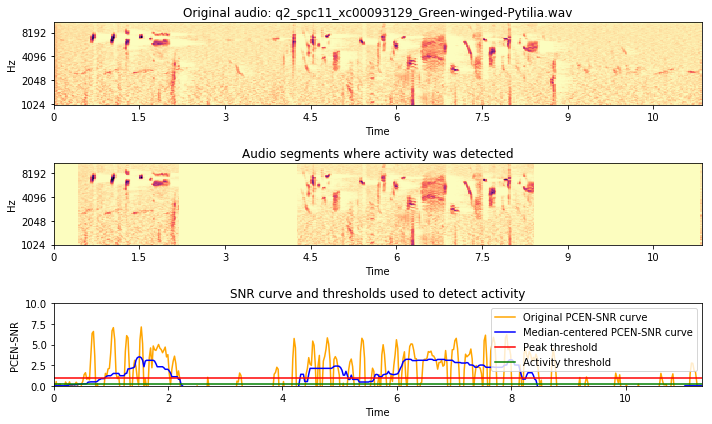

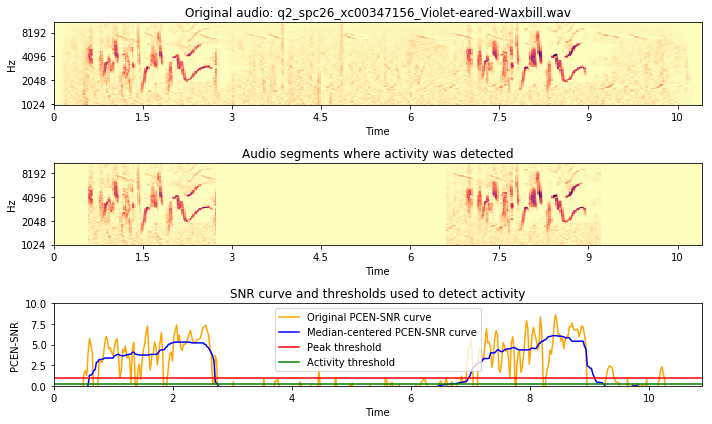

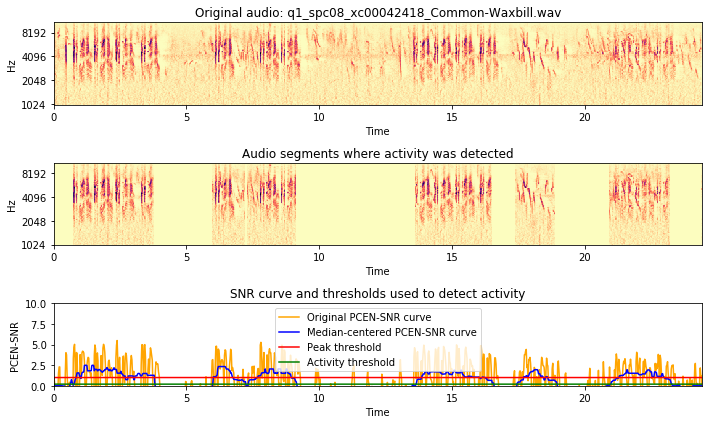

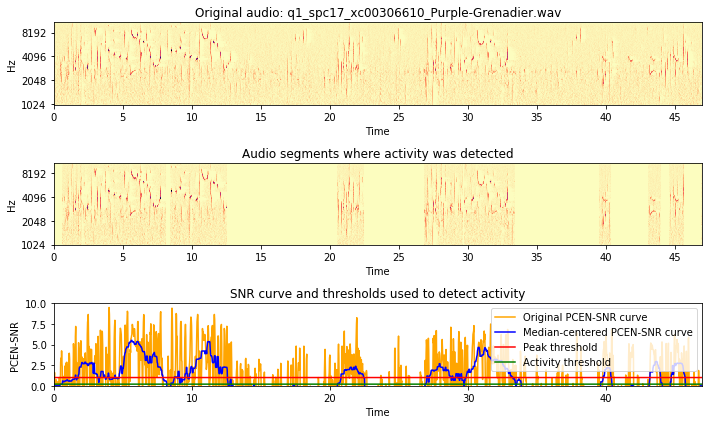

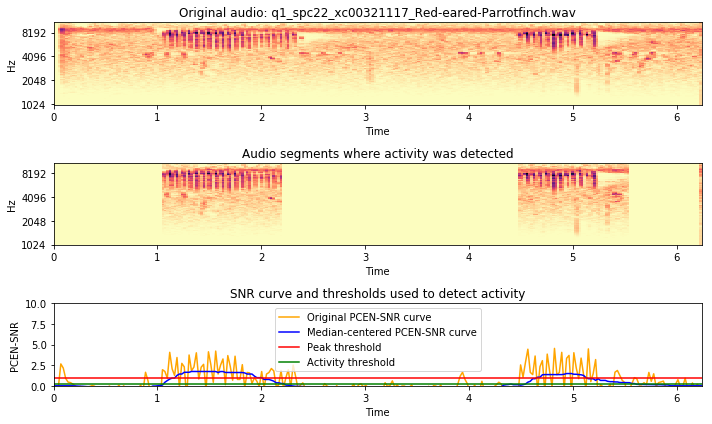

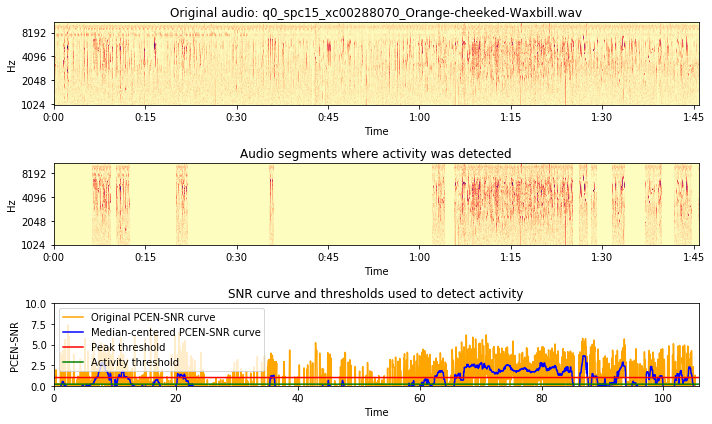

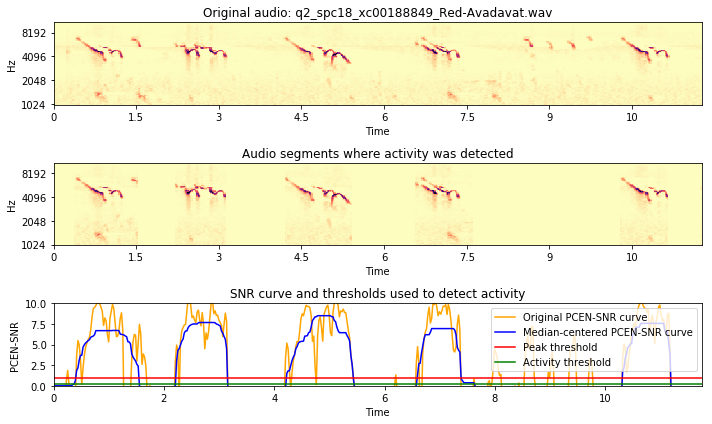

In [203]:
for naudio in range(len(audio_list)): 
#for naudio in range(1):
    # LOAD AUDIO
    file_name = audio_list[naudio]
    y,sr = librosa.load(file_name)
    #librosa.display.waveplot(y,sr=sr, x_axis='time')

    # APPLY PCEN-SNR
    [begs, ends] = detect_activity(y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, 
            hop_length=hop_length, gain=gain, bias=bias, power=power, 
            pcen_time_constant=pcen_time_constant, eps=eps,
            medfilt_time_constant=medfilt_time_constant, normalized=normalized, 
            peak_threshold=peak_threshold, activity_threshold=activity_threshold)

    # VISUALIZE SEGMENTATION

    # Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(y, sr=sr, fmin=fmin, fmax=fmax, 
        hop_length=hop_length, n_mels=n_mels)
    # Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    # compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
    # apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        mfilt_pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)

    # plot PCEN spectrogram
    times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    librosa.display.specshow(pcen, sr=sr,fmin=fmin, fmax=fmax,
        x_axis='time', y_axis='mel', cmap='magma_r')
    #for nseg in np.arange(begs.size):
    #    plt.axvline(x=begs[nseg])
    #    plt.axvline(x=ends[nseg])
    plt.title('Original audio: %s' %file_name)
    
    # plot PCEN spectrogram with blocked out areas where the snr was too low. 
    begs0 = np.append(begs,times[-1])
    ends0 = np.append(np.arange(1), ends)
    pcen_blockedout = copy.deepcopy(pcen)
    for nseg in np.arange(ends0.size):
        loc_b = np.argmin(abs(times - begs0[nseg]))
        loc_e = np.argmin(abs(times - ends0[nseg]))
        pcen_blockedout[:,loc_e:loc_b] = np.amin(pcen)
    plt.subplot(3,1,2)
    librosa.display.specshow(pcen_blockedout, sr=sr,fmin=fmin, fmax=fmax,
            x_axis='time', y_axis='mel', cmap='magma_r')
    plt.title('Audio segments where activity was detected')

    # plot median-filtered pcen-snr detection function along with the peak and activity thresholds
    peak_thresh_plt = np.matlib.repmat(peak_threshold,times.size,1)
    activity_thresh_plt = np.matlib.repmat(activity_threshold,times.size,1)
    plt.subplot(3, 1, 3)
    plt.plot(times, pcen_snr, color="orange")
    plt.plot(times, mfilt_pcen_snr, color="blue")
    plt.plot(times, peak_thresh_plt, color = "red")
    plt.plot(times, activity_thresh_plt, color = "green")
    plt.xlim(times[0], times[-1])
    plt.ylim(0,10)
    plt.xlabel('Time')
    plt.ylabel('PCEN-SNR')
    plt.tight_layout()
    plt.title('SNR curve and thresholds used to detect activity')
    plt.legend(('Original PCEN-SNR curve','Median-centered PCEN-SNR curve','Peak threshold','Activity threshold'))
